### Latent Semantic Analysis

#### Author: Yifan Wang

LSA is a classic method for information retrieval for text documents, we will implement LSA to extract latent topic in some text documents.


Basic Architecture of LSA:

1.  TFIDF to get score for each word

2. Construct TFIDF matrix

3. Performs SVD to extract the latent topics

Following are the helper modules of TFIDF and SVD:

In [134]:
import numpy as np
from collections import Counter
from nltk.corpus import stopwords


# TFIDF Algorithm
class TFIDF(object):
    def __init__ (self, stopwords):
        self.stopwords = stopwords
        
        
    def tokenizer(self,data):
        '''tokenize text into list of words and Remove SW'''


        data = [x.lower().split() for x in data]

        # Remove Stopwords:
        clean_data = []
        for doc in data:
            clean_data.append([w for w in doc if w not in self.stopwords])
        
        self.data = clean_data
#         print(self.data)
    
    
    def tfidf_word2id(self):
        # Word to Index
        new_data = []
        word2id = {}
        counter = 1
        for doc in self.data:
            new_doc = []
            for tok in doc:
                if tok not in word2id:
                    word2id[tok] = str(counter)
                    counter += 1

                new_doc.append(word2id[tok])
            new_data.append(new_doc)

        self.word2id = word2id
        self.data = new_data

    
    def term_freq(self):
        tf = []
        for doc in self.data:
            doc_count = Counter(doc)
            doc_tf = { x: doc_count[x]/len(doc) for x in doc_count}
            tf.append(doc_tf)
        self.tf  = tf
    
    def inv_doc_freq(self):
        idf = {}
        idxs = list(set([j for i in self.data for j in i]))
        N = len(self.data)
        for idx in idxs:
            nd = len([doc for doc in self.data if idx in doc])
            idf[idx] = np.log10(1+ (N/nd))
        self.idf = idf
        
    def tfidf_raw(self):
        results = []
        for doc in self.tf:
            result = {}
            for idx in doc:
                result[idx] = doc[idx] * self.idf[idx]
            results.append(result)
        self.tfidf_raw_results = results
    
    def tfidf_id2word(self):
        tfidf_results = []
        self.id2word = {v: k for k, v in self.word2id.items()}
        
        for doc in self.tfidf_raw_results:
            res = {}
            for idx in doc:
#                 print(idx)
#                 print(self.id2word[idx])
#                 print(doc[idx])
#                 print('---')
                
                res[self.id2word[idx]] = doc[idx]
            tfidf_results.append(res)
        return tfidf_results
        
    
    def fit(self,X):
        self.tokenizer(X)
        self.tfidf_word2id()
        self.term_freq()
        self.inv_doc_freq()
        self.tfidf_raw()
        


        
        
        

Let's first get our test data and stopwords(default collection of stopwords in NLTK):

In [160]:
data = [
    'i love my lunch',
    'how do you think the weather today',
    'what do you like to eat for your lunch',
    'i hate school',
    'ice cream is bad for your health',
    'not going to school today',
    'which movie do you like to watch',
    'i love to drink coke',
    'too much food make me fat',
    'do you think the weather will be better',
    'movie quality really depends on the genre',
    'school is the place to study',
    'what kind of food do you like to eat',
    'learn make me feel happy',
    'i think the weather will be sunny tomorrow',
    'what is your favorite subject to lear',
    'what do you like for lunch',
    'what is your favorite subject at school',
    'tomorrow might be sunny',
    'going to cinema to watch something',
    'my favorite lunch is noodle',
    'i hate to study english',
    'do you think tomorrow will be rainy',
    'actions movies are the worst',
    'do you like eat pizza',
    'lets go to learn something',
    'sunny or windy which one prefer for today',
    'what genre do you like in cinema',
    'pizza or ice cream what we go for',
    'is english your favorite subject',
    'hope tomorrow will not be windy',
    'i prefer action than romance genre'
]

# Stopwords:
sw = list(set(stopwords.words('english')))

In [161]:
# Pre-label the data:
label = [
    'food','weather','food','school',
    'food','school','movie','food',
    'food','weather','movie','school',
    'food','learn','weather','learn',
    'food','school','weather','movie',
    'food','learn', 'weather','movie',
    'food', 'learn', 'weather','movie',
    'food','learn','weather','movie'
    
]

In [162]:
len(data)

32

In [163]:
len(label)

32

Get TFIDF score:

In [164]:

tfidf = TFIDF(stopwords=sw)
tfidf.fit(data)
res = tfidf.tfidf_id2word()

In [165]:
# Peek some tfidf scores:
res[:3]

[{'love': 0.6152244606891369, 'lunch': 0.47712125471966244},
 {'think': 0.3180808364797749,
  'today': 0.355648929876871,
  'weather': 0.355648929876871},
 {'eat': 0.355648929876871,
  'like': 0.26721078207772214,
  'lunch': 0.3180808364797749}]

Now let's construct TFIDF Matrix:

In [166]:
#word to index dict:
word_idx = tfidf.word2id
# Initialize tfidf matrix:
tfidf_mat = np.zeros((len(res),len(word_idx)))


# Fill the values
for doc_i in range(len(res)):
    doc = res[doc_i]
    for key in doc:
        tfidf_mat[doc_i,int(word_idx[key])-1 ] = doc[key]
        
        
    
# Peek our tfidf matrix:  Each row is a document, each column is a word, the values are the tfidf scores:  
    
tfidf_mat[:5,:5] 

array([[0.61522446, 0.47712125, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.31808084, 0.35564893, 0.35564893],
       [0.        , 0.31808084, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ]])

Finally we can use SVD to get the latent topics.
We will borrow Numpy's implementation to make the work easier:

In [167]:
from numpy import linalg as la
import matplotlib.pyplot as plt

#Transpose the mat for svd:
tfidf_mat_t = tfidf_mat.T

U,sigma,V=la.svd(tfidf_mat)

In [168]:
# Let's use the sigular values to determine the dimension: 
def get_svd_dim(sigma):
    sv_sum = np.sum(sigma)
    total = 0
    for i in range(len(sigma)):
        val = sigma[i]
        total += val
        if total > .5 * sv_sum:
            return(i)

svd_dim = get_svd_dim(sigma)       
print(svd_dim)

11


In [169]:
def reconstruction(U,sigma,svd_dim):
    return  U.dot(np.diag(sigma)[:,:svd_dim])

In [170]:
new_mat = reconstruction(U,sigma,svd_dim)

[20.0, 15.0]


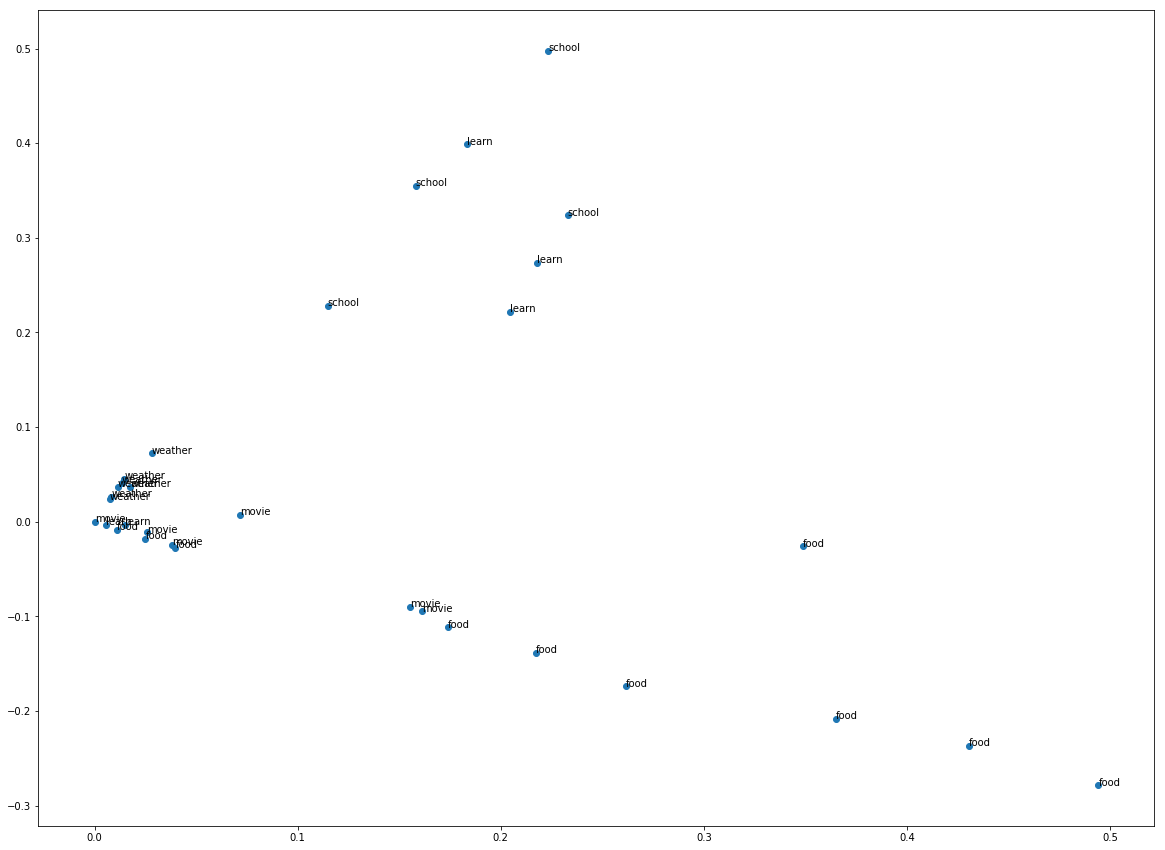

In [171]:

# Let's view the first 2 dimensions, similar topics are together:


fig_size = plt.rcParams["figure.figsize"]
print(fig_size)
fig_size[0] = 20
fig_size[1] = 15
plt.rcParams["figure.figsize"] = fig_size


fig,ax = plt.subplots()
x = new_mat[:,0]
y = new_mat[:,1]
ax.scatter(x = x,y = y)

for i,txt in enumerate(label):
    ax.annotate(txt, (x[i], y[i]))

